In [1]:
import pdb
from config import Config
import psycopg2
import psycopg2.extras
import pandas as pd
import numpy as np
from objects import gestures_map
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
from matplotlib.dates import date2num
from matplotlib import pyplot as plt
import time
import copy
import datetime
import math

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# gather necessary data from database
conn = psycopg2.connect(host=Config.DB_HOST, database=Config.DB_USER, user=Config.DB_USER, password=Config.DB_PASS)

# gather data from model_scores
query = "SELECT * FROM model_scores" 
df_model_scores = pd.read_sql(query, con=conn)

# gather data from frames
query = "SELECT * FROM frames" # replace with frames in production 
df_frames = pd.read_sql(query, con=conn)

# list gestures
gestures = list(gestures_map.values())

# define figure directory
# figure_dir = os.path.join(os.path.abspath(os.path.dirname(__file__)), 'figures')

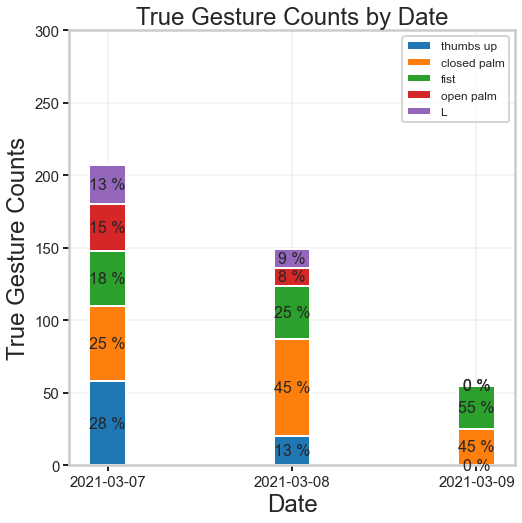

In [2]:
## evaluate - most popular gestures
# There may be trends in which gestures are popular depending on time of day, location, etc or perhaps this trend will be random

# reduce date to year, month, date
df_frame_gest_pop = copy.deepcopy(df_frames)
df_frame_gest_pop['date'] = df_frame_gest_pop['date'].dt.date

# get counts of each gesture for each date
gestures_with_time = df_frame_gest_pop[['true_gest','date']][df_frame_gest_pop['true_gest']!='']
gestures_with_time = pd.DataFrame(gestures_with_time.value_counts())
gestures_with_time.reset_index(level=0, inplace=True)
gestures_with_time = gestures_with_time.sort_values('date')
gestures_with_time.reset_index(level=0, inplace=True)
gestures_with_time = gestures_with_time.rename(columns={0: 'counts'})

# generate label for each unique date
labels = []
dates = gestures_with_time['date'].unique()
for date in dates:
    labels.append(date.strftime("%Y-%m-%d"))
    
# generate dictionary containing count and percentage information for each gesture for each date
gesture_dict = {}
for gesture in gestures_with_time['true_gest'].unique():
    gesture_dict[gesture] = {}
    gesture_dict[gesture]['counts'] = [0 for _ in range(len(dates))]
    gesture_dict[gesture]['percentages'] = [0 for _ in range(len(dates))]
date_total_gestures = gestures_with_time.groupby('date').sum()['counts']
date_index = 0
for i in range(len(gestures_with_time)):
    try:
        if gestures_with_time['date'][i-1] != gestures_with_time['date'][i]:
            date_index += 1
    except:
        pass
    gesture_counts = gestures_with_time['counts'][i]
    gesture = gestures_with_time['true_gest'][i]
    gesture_dict[gesture]['counts'][date_index] = gesture_counts
    gesture_dict[gesture]['percentages'][date_index] = gesture_counts*100 / date_total_gestures[date_index]

# generate bar chart showing relative popularity of different gestures over time 
fig, ax = plt.subplots(figsize=(8,8))
width = 0.2
prev_gesture_counts = [0 for _ in range(len(dates))]
total_height = [0 for _ in range(len(dates))]
for gesture in gesture_dict.keys():
    gesture_counts = gesture_dict[gesture]['counts']
    if prev_gesture_counts == [0 for _ in range(len(dates))]:
        ax.bar(labels, gesture_counts, width=width, label=gesture)
    elif prev_gesture_counts != [0 for _ in range(len(dates))]:
        ax.bar(labels, gesture_counts, width=width, bottom=prev_gesture_counts, label=gesture)
    prev_gesture_counts = [sum(x) for x in zip(prev_gesture_counts, gesture_counts)]
    count = 0
    gesture_percentages = gesture_dict[gesture]['percentages']
    for j in ax.patches[-len(dates):]:
        width, height = j.get_width(), j.get_height()
        x, y = j.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f} %'.format(gesture_percentages[count]), fontsize=16, horizontalalignment='center', verticalalignment='center')
        total_height[count] += height
        count+=1
ax.set_ylabel('True Gesture Counts')
ax.set_xlabel('Date')
ax.set_title('True Gesture Counts by Date')
# define y_limits
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100
ceiling = roundup(math.ceil(max(total_height)*1.25))
step = 50
num_steps = int(ceiling/step+1)
yticks = np.linspace(0, ceiling, num_steps)
ax.set_yticks(yticks)
ax.tick_params(labelsize=15, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('test_output.png')

In [3]:
## evaluate - classification report and confusion matrix for each model
# This informs of relative performance of top 3 models. Perhaps some are better at predicting certain gestures compared to others
import dataframe_image as dfi

# define dataframe styling
# Set CSS properties for caption
cap_props = [
    ('font-size', '20px'),
    ('text-align', 'center'),
    ('font-weight', 'bold'),
    ('color', '#000000'),
    ('text-align', 'center'),
    ('background-color', '#ECECEC'),
    ]

# Set CSS properties for headers
th_props = [
    ('font-size', '14px'),
    ('text-align', 'center'),
    ('background-color', '#ECECEC'),
    ]

# Set CSS properties for data
td_props = [
    ('font-size', '14px'),
    ]

# Set table styles
styles = [
    dict(selector="caption", props=cap_props),
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props),
]

def color_on_threshold(value):
    threshold = 0.5
    if value < threshold:
        color = 'red'
    elif value >= threshold:
        color = 'green'
    return f'color: {color}'

labels = list(gestures_map.values())
for i in range(3):
    y_true = eval(df_model_scores['true_gestures'][i].replace('{','[').replace('}',']'))
    y_pred = eval(df_model_scores['predicted_gestures'][i].replace('{','[').replace('}',']'))
    model_name = df_model_scores['model_name'][i]
    eval_date = df_model_scores['evaluation_date'][i]
    
    # generate and save classification_report
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    caption = f'Classification Report for {model_name} <br> (trained {eval_date})'
    df_styled = df_report.style.set_precision(3).applymap(color_on_threshold, subset=['precision', 'recall' ,'f1-score']).set_caption(caption).set_table_styles(styles)
    dfi.export(df_styled, 'classification_report.png')
    
    # generate and save confusion matrix
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=labels, index=labels)
    caption = f'Confusion Matrix for {model_name} <br> (trained {eval_date})'
    df_styled = df_confusion_matrix.style.set_caption(caption).set_table_styles(styles)
    dfi.export(df_styled, 'confusion_matrix.png')

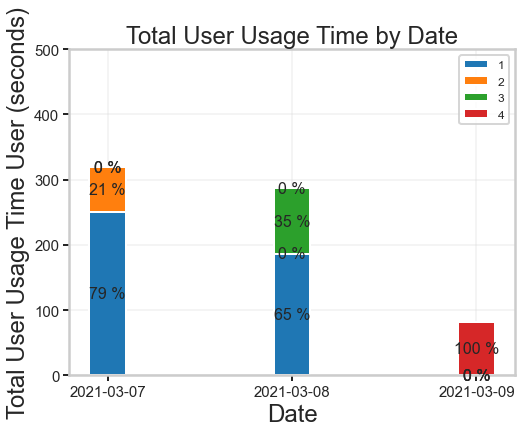

,date,user_id,session_id,duration
0,2021-03-07,1,3,251
1,2021-03-07,2,1,68
2,2021-03-07,3,0,0
3,2021-03-07,4,0,0
4,2021-03-08,1,7,186


In [4]:
## evaluate - user daily usage
# It may be valuable to know which users are using the application most, if there are notable trends with respect to user usage, etc. This should be modified such that users that comprise consume less than 5% of total usage are merged to a single group. 

# get duration spent by each user for each date
user_session_info = df_frames.groupby(['user_id', 'session_id']).agg({'date': ['min', 'max']})
user_session_info.columns = user_session_info.columns.droplevel(0)
user_session_info.reset_index(level=[0,1], inplace=True)
user_session_info['duration'] = (user_session_info['max'] - user_session_info['min']).dt.total_seconds()
user_session_info['date'] = user_session_info['min'].dt.date
user_session_info = user_session_info.drop(['max', 'min'], axis=1)

# add blank entries for users that do not login on any given date. This is necessary for generating the stacked bar plot cleanly
for date in user_session_info['date'].unique():
    for user in user_session_info['user_id'].unique():
        if date not in list(user_session_info[user_session_info['user_id'] == user]['date']):
            blank_entry = [user, 0, 0, date]
            blank_df = pd.DataFrame([blank_entry], columns=list(user_session_info.columns))
            user_session_info = user_session_info.append([blank_df], ignore_index=True)
user_session_info = user_session_info.groupby(['date', 'user_id']).sum()
user_session_info['duration'] = user_session_info['duration'].astype(int)
user_session_info.reset_index(level=[0,1], inplace=True)
            
# generate dictionary containing total usage duration and percentage of total time for each user for each date
user_dict = {}
for user in user_session_info['user_id'].unique():
    user_dict[user] = {}
    user_dict[user]['duration'] = [0 for _ in range(len(dates))]
    user_dict[user]['percentages'] = [0 for _ in range(len(dates))]
date_total_duration = user_session_info.groupby('date').sum()['duration']
date_index = 0
for i in range(len(user_session_info)):
    try:
        if user_session_info['date'][i-1] != user_session_info['date'][i]:
            date_index += 1
    except:
        pass
    user_durations = user_session_info['duration'][i]
    user = user_session_info['user_id'][i]
    user_dict[user]['duration'][date_index] = user_durations
    user_dict[user]['percentages'][date_index] = user_durations*100 / date_total_duration[date_index]

# generate label for each unique date
labels = []
dates = user_session_info['date'].unique()
for date in dates:
    labels.append(date.strftime("%Y-%m-%d"))
    
# generate bar chart showing relative usage of users over time
fig, ax = plt.subplots(figsize=(8,6))
width = 0.2
prev_user_durations = [0 for _ in range(len(dates))]
total_height = [0 for _ in range(len(dates))]
for user in user_dict.keys():
    user_durations = user_dict[user]['duration']
    if prev_user_durations == [0 for _ in range(len(dates))]:
        ax.bar(labels, user_durations, width=width, label=user)
    elif prev_gesture_counts != [0 for _ in range(len(dates))]:
        ax.bar(labels, user_durations, width=width, bottom=prev_user_durations, label=user)
    prev_user_durations = [sum(x) for x in zip(prev_user_durations, user_durations)]
    count = 0
    user_percentages = user_dict[user]['percentages']
    for j in ax.patches[-len(dates):]:
        width, height = j.get_width(), j.get_height()
        x, y = j.get_xy() 
        ax.text(x+width/2, y+height/2, '{:.0f} %'.format(user_percentages[count]), fontsize=16, horizontalalignment='center', verticalalignment='center')
        total_height[count] += height
        count+=1
ax.set_ylabel('Total User Usage Time User (seconds)')
ax.set_xlabel('Date')
ax.set_title('Total User Usage Time by Date')
# define y_limits
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100
ceiling = roundup(math.ceil(max(total_height)*1.5))
step = 100
num_steps = int(ceiling/step+1)
yticks = np.linspace(0, ceiling, num_steps)
ax.set_yticks(yticks)
ax.tick_params(labelsize=15, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)
ax.legend(loc='upper right', fontsize=12)

plt.show() 

user_session_info.head()

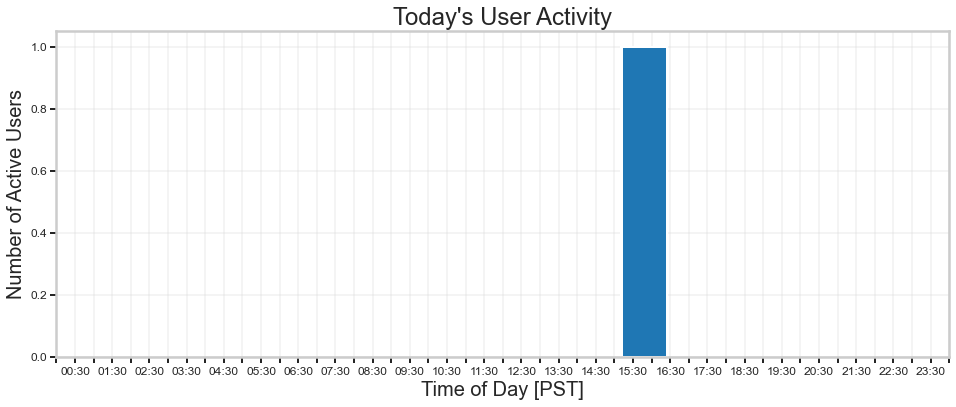

In [5]:
## evaluate - total daily user activity
# It is always good to know which times of day most users are using the product to inform advertising strategy or future product development.
# generate df containing number of users during each minute
df_users_per_minute = df_frames[['date', 'user_id']]
df_users_per_minute = df_users_per_minute[df_users_per_minute['date'].dt.date == datetime.datetime.now().date()]
df_users_per_minute['date'] = df_users_per_minute['date'].dt.floor('Min')
df_users_per_minute = pd.DataFrame(df_users_per_minute.drop_duplicates()['date'].value_counts())
df_users_per_minute.reset_index(level=0, inplace=True)
df_users_per_minute = df_users_per_minute.rename(columns={'index': 'date', 'date': 'user_count'})
df_users_per_minute = df_users_per_minute.sort_values('date', ignore_index=True)

# define x-axis limits and labels. plot will show statisticss for every 30 minutes of today only. need to modify to account for end of month / year
start = datetime.datetime(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day, 0, 0, 0)
end = datetime.datetime(datetime.datetime.now().year, datetime.datetime.now().month, datetime.datetime.now().day+1, 0, 0, 0)
x_lims = pd.date_range(start, end, periods=49).to_pydatetime()
x_labels = []
for i in range(len(x_lims)):
    if i%2 != 0:
        x_labels.append(x_lims[i].strftime('%H:%M'))
    else: 
        x_labels.append('')

# plot results
fig, ax = plt.subplots(figsize= (16,6))
ax.bar(x=df_users_per_minute['date'], height=df_users_per_minute['user_count'], width=0.05)
ax.set_xlabel('Time of Day [PST]', fontsize=20)
ax.set_ylabel('Number of Active Users', fontsize=20)
ax.set_title("Today's User Activity")
ax.set_xticks(x_lims)
ax.set_xticklabels(x_labels)
ax.tick_params(labelsize=12, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)

,date,open palm acc,closed palm acc,L acc,fist acc,thumbs up acc
0,2021-03-07,0.625,0.500000,0.666667,0.526316,0.431034
1,2021-03-08,0.750,0.268657,0.461538,0.810811,0.400000
2,2021-03-09,NaN,0.360000,NaN,0.066667,NaN


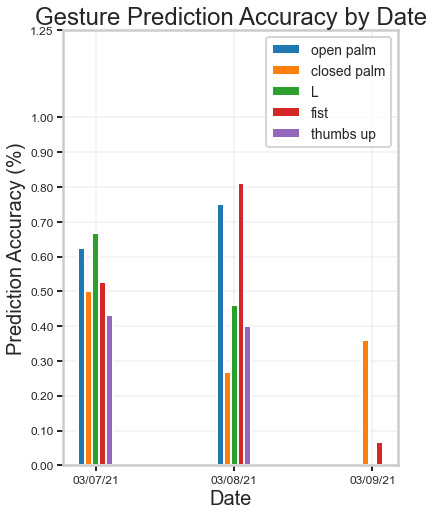

In [7]:
## evaluate - daily prediction accuracy for each gesture
# This informs us about which gestures are more difficult to predict than others. I significant change in gesture prediction accuracy may correlate with a change in which model is currently implemented.

# generate table with prediction accuracy for each gesture
df_gest_acc_by_date = df_frames[df_frames['true_gest'] != ''][['date', 'true_gest', 'pred_gest']]
df_gest_acc_by_date['date'] = df_gest_acc_by_date['date'].dt.floor('D')

try:
    del df_combined_acc
except:
    pass

column_names = []
for gesture in gestures:
    df_temp = df_gest_acc_by_date[df_gest_acc_by_date['true_gest'] == gesture]
    column_name = gesture + ' acc'
    df_temp[column_name] = df_temp['pred_gest'] == gesture
    df_temp = df_temp[['date', column_name]]
    df_temp = pd.DataFrame(df_temp.groupby('date')[column_name].mean())
    df_temp.reset_index(level=0, inplace=True)
    try: 
        df_combined_acc = df_combined_acc.merge(df_temp, how='outer', on='date')
    except:
        df_combined_acc = copy.deepcopy(df_temp)

# define x-axis limits and labels. plot will show statistics for each day
start = df_gest_acc_by_date['date'].min()
end = df_gest_acc_by_date['date'].max()
x_lims = pd.date_range(start, end, freq='D').to_pydatetime()
x_labels = []
for i in range(len(x_lims)):
    x_labels.append(x_lims[i].strftime('%D'))

# generate bar chart showing prediction accuracy for different gestures
fig, ax = plt.subplots(figsize= (6,8))
width = 0.05
gesture_cols = list(df_combined_acc.columns)[1:]
for i in range(len(gestures)):
    gesture = gestures[i]
    test = date2num(df_combined_acc['date'])+width*(i-(len(gestures)-1)/2)
    ax.bar(x=test, height=df_combined_acc[gesture_cols[i]], width=width, label=gesture)

ax.set_xlabel('Date', fontsize=20)
ax.set_xticks(x_lims)
ax.set_xticklabels(x_labels)
ax.set_ylabel('Prediction Accuracy (%)', fontsize=20)
ylims = list(np.linspace(0,1,11))
ylims.append(1.25)
ax.set_yticks(ylims)
ax.set_title("Gesture Prediction Accuracy by Date")
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(labelsize=12, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)

df_combined_acc.head()

In [7]:
# Additional plots to make
    # Show where users are based on IP address
    # Plot request/ response processing time throughout the day. This may correlate with peak usage times